In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np

In [2]:
#get data

from data_utils import load_fashion_mnist

trX, teX, _, _ = load_fashion_mnist(onehot=False)

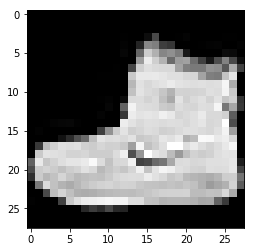

In [3]:
#view data

import matplotlib.pyplot as plt

plt.imshow(trX[0].reshape(28,28), cmap=plt.get_cmap('gray')) #need cmap thing or else is weird colour
plt.show()

In [4]:
#convert from numpy arrays to torch tensors

trX = torch.from_numpy(trX).float()
teX = torch.from_numpy(teX).float()

In [5]:
#create model

class AutoEncoder(nn.Module):
    def __init__(self, input_size):
        super(AutoEncoder, self).__init__()
        
        # to find the size (width x height) of a square image leaving a conv layer, the equation is:
        # Wo = ((Wi−F+2*P)/S)+1, 
        # Wo is the width of the image output
        # Wi is the width of the image going in
        # F is the filter width (aka 'kernel size')
        # P is the padding
        # S is the stride
        
        self.enc_conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=3, padding=1)
        # Wo = ((28-3+2*1)/3)+1 = 10
        self.enc_conv2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1)
        # Wo = ((5-3+2*1)/2)+1 = 3
        
        # to find the size (width x height) of a square image leaving a conv-transpose layer, the equation is:
        # Wo = (Wi-1)*S-2*P+F

        self.dec_conv1 = nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=3, stride=2)
        # Wo = (2-1)*2-2*0+3 = 5
        self.dec_conv2 = nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=5, stride=3, padding=1)
        # Wo = (5-1)*3-2*1+5 = 15
        self.dec_conv3 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=2, stride=2, padding=1)
        # Wo = (15-1)*2-2*1+2 = 28
        
        #for pooling layers
        # Wo = floor((Wi+2*P-(F-1)-1)/S+1) 
        
    def forward(self, x):
        #x = [32, 1, 28, 28]
        x = self.enc_conv1(x)
        #x = [32, 16, 10, 10]
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        #x = [32, 16, 5, 5]
        x = self.enc_conv2(x)
        #x = [32, 8, 3, 3]
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=1)
        #x = [32, 8, 2, 2]
        encoded = x
        x = self.dec_conv1(x)
        #x = [32, 16, 5, 5]
        x = F.relu(x)
        x = self.dec_conv2(x)
        #x = [32, 8, 15, 15]
        x = F.relu(x)
        x = self.dec_conv3(x)
        #x = [32, 1, 28, 28]
        decoded = F.sigmoid(x)
        return encoded, decoded

In [6]:
#create instance of AutoEncoder class

autoencoder = AutoEncoder(784)

In [7]:
#define some parameters

epochs = 10
batch_size = 32
learning_rate = 0.001
momentum = 0.9

In [8]:
#for plotting

plot_loss = []
plot_correct = []

In [9]:
#define loss and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [ ]:
#training function

def train(model, criterion, optimizer, x, y):
    x = Variable(x, requires_grad=False)
    y = Variable(y, requires_grad=False)
    
    # Reset gradient
    optimizer.zero_grad()

    # Forward
    _, decoded = model.forward(x)
    loss = criterion(decoded, y)

    # Backward
    loss.backward()

    # Update parameters
    optimizer.step()

    return loss.data[0]

In [ ]:
#run the training

num_examples = trX.shape[0]
num_batches = num_examples // batch_size

#need to reshape to 4D to feed into convolutional neural net
trX = trX.view(-1, 1, 28, 28) #from [60000,784] to [60000, 1, 28, 28], the '1' is the number of colour channels
teX = teX.view(-1, 1, 28, 28)

for e in range(1, epochs+1):
    loss = 0.
    for k in range(num_batches):
        start, end = k * batch_size, (k + 1) * batch_size
        loss += train(autoencoder, criterion, optimizer, trX[start:end], trX[start:end])
    plot_loss.append(loss/num_batches)
    print("Epoch %02d, loss = %f" % (e, loss / num_batches))

Epoch 01, loss = 0.042735
Epoch 02, loss = 0.025688
Epoch 03, loss = 0.022542
Epoch 04, loss = 0.021145
Epoch 05, loss = 0.020286
Epoch 06, loss = 0.019674


In [ ]:
plt.plot(plot_loss)
plt.xlabel('Epoch')
plt.ylabel('Avg. Loss per Epoch (on Training Set)')
plt.show()

In [ ]:
teX = Variable(teX, requires_grad=False)

In [ ]:
_, decoded = autoencoder.forward(teX)

In [ ]:
#view some

num_display = 5

fig = plt.figure()

for i in range(num_display):
    fig.add_subplot(1,num_display,i+1)
    plt.imshow(np.reshape(teX[i+5].data.numpy(), (28,28)), cmap=plt.get_cmap('gray'))
    
fig = plt.figure()

for i in range(num_display):
    fig.add_subplot(1,num_display,i+1)
    plt.imshow(np.reshape(decoded[i+5].data.numpy(), (28,28)), cmap=plt.get_cmap('gray'))
    
plt.show()